In [1]:
from tcn import TCN, tcn_full_summary
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('../Implementation/CSVFiles/2022-09-26-18-56-30-ground_truth-state.csv')
test_data  = pd.read_csv('../Implementation/CSVFiles/2022-09-26-18-56-30-odom-local.csv')
odom_data  = pd.read_csv('../Implementation/CSVFiles/2022-09-26-18-56-30-odom.csv')

In [3]:
train_data.drop(['.header.seq', '.header.frame_id', '.child_frame_id', 'time', '.pose.covariance', '.twist.covariance'], axis=1, inplace=True)
test_data.drop(['.header.seq', '.header.frame_id', '.child_frame_id', 'time', '.pose.covariance', '.twist.covariance'], axis=1, inplace=True)
odom_data.drop(['.header.seq', '.header.frame_id', '.child_frame_id', 'time', '.pose.covariance', '.twist.covariance'], axis=1, inplace=True)

In [4]:
print(test_data.shape)
print(train_data.shape)
print(len(train_data))
train_data.head()
test_data.head()

(4716, 15)
(4716, 15)
4716


,.header.stamp.secs,.header.stamp.nsecs,.pose.pose.position.x,.pose.pose.position.y,.pose.pose.position.z,.pose.pose.orientation.x,.pose.pose.orientation.y,.pose.pose.orientation.z,.pose.pose.orientation.w,.twist.twist.linear.x,.twist.twist.linear.y,.twist.twist.linear.z,.twist.twist.angular.x,.twist.twist.angular.y,.twist.twist.angular.z
0,6,520000000,-1.670000e-07,1.070000e-07,0.193719,-0.000913,-0.005552,0.000003,0.999984,-0.000009,0.000008,0.000468,-0.000001,0.000550,-0.000047
1,6,540000000,-1.650000e-07,1.060000e-07,0.193718,-0.000913,-0.005552,0.000004,0.999984,-0.000008,0.000008,0.000463,-0.000001,0.000543,-0.000046
2,6,580000000,-1.630000e-07,1.050000e-07,0.193718,-0.000913,-0.005552,0.000004,0.999984,-0.000008,0.000008,0.000453,-0.000001,0.000531,-0.000045
3,6,580000000,-1.630000e-07,1.050000e-07,0.193718,-0.000913,-0.005552,0.000004,0.999984,-0.000008,0.000008,0.000453,-0.000001,0.000531,-0.000045
4,6,600000000,-1.610000e-07,1.040000e-07,0.193717,-0.000913,-0.005552,0.000004,0.999984,-0.000008,0.000008,0.000449,-0.000001,0.000525,-0.000045


In [5]:
dataset = odom_data.values
# split into input (X) and output (y) variables
X, y = dataset[:, [0,1,5,6,7,8,9,10,11,12,13,14]], dataset[:, [2,3,4]]

print(X.shape)
print(y.shape)

(4716, 12)
(4716, 3)


(4716, 1)
(4716, 1)


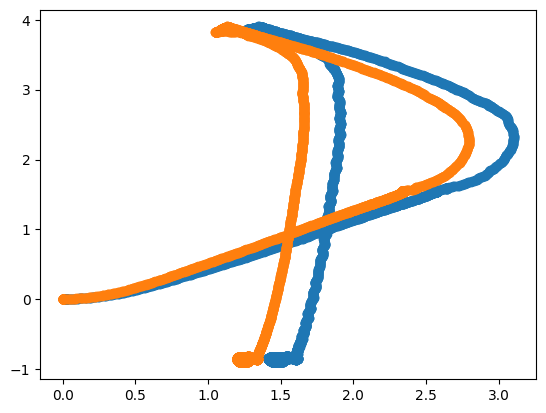

In [6]:
#Ground Truth
# importing Matplotlib and Numpy Packages
import numpy as np
import matplotlib.pyplot as plt

dataset_truth = train_data.values
dataset_odom = odom_data.values
# generating two arrays from 10 to 1 and from 1 to 10
x, y = dataset_truth[:, [2]], dataset[:, [3]]
x2, y2 = dataset_odom[:, [2]], dataset[:, [3]]
print(x2.shape)
print(y2.shape)

# plot our list in X,Y coordinates
plt.scatter(x, y)
plt.scatter(x2, y2)
plt.show()


In [ ]:
X, y = X.astype('float'), y.astype('float')
n_features = X.shape[1]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
print(n_features)
X_train.shape

In [ ]:
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()
train_data = RS.fit_transform(train_data)
test_data  = RS.transform(test_data)

In [ ]:
test_data.shape
n_epochs = 4
n_splits =  5

In [ ]:
kf = KFold(n_splits=n_splits, shuffle=False)
test_preds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(train_data, targets)):
    print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
    X_train, X_valid = train_data[train_idx], train_data[test_idx]
    y_train, y_valid = targets[train_idx], targets[test_idx]
    
    scheduler = tf.keras.optimizers.schedules.ExponentialDecay(5e-4,0.995,100)
    
    model = keras.models.Sequential([
        TCN(input_shape=(-1,n_features), nb_filters=256, return_sequences=True, dilations=[1, 2, 4]),
        keras.layers.Dense(1)
    ])
    
    model.compile(optimizer="adam", loss="mae",
                  metrics=keras.metrics.MeanAbsoluteError())
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=n_epochs, 
                        batch_size=20000, 
                        callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])
    
    model.save(f'Fold{fold+1} weights')
    test_preds.append(model.predict(test_data).squeeze().reshape(-1, 1).squeeze())